卷积SNN训练MNIST数据集

In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from spikingjelly.activation_based import neuron, functional, surrogate, layer
import os
import time
from torch.cuda import amp
from spikingjelly import visualizing

定义CSNN

In [3]:
class CSNN(nn.Module):
    def __init__(self, T: int, channels: int):
        super().__init__()
        self.T = T

        self.conv_fc = nn.Sequential(
            layer.Conv2d(1, channels, kernel_size=3, padding=1, bias=False),
            layer.BatchNorm2d(channels),
            neuron.IFNode(surrogate_function=surrogate.ATan()),
            layer.MaxPool2d(2, 2),  # 14 * 14

            layer.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
            layer.BatchNorm2d(channels),
            neuron.IFNode(surrogate_function=surrogate.ATan()),
            layer.MaxPool2d(2, 2),  # 7 * 7

            layer.Flatten(),
            layer.Linear(channels * 7 * 7, channels * 4 * 4, bias=False),
            neuron.IFNode(surrogate_function=surrogate.ATan()),

            layer.Linear(channels * 4 * 4, 10, bias=False),
            neuron.IFNode(surrogate_function=surrogate.ATan()),
        )

        functional.set_step_mode(self, step_mode='m')


    def forward(self, x: torch.Tensor):
        x_seq = x.unsqueeze(0).repeat(self.T, 1, 1, 1, 1)  # [N, C, H, W] -> [T, N, C, H, W]
        x_seq = self.conv_fc(x_seq)
        fr = x_seq.mean(0)
        return fr
    
    def spiking_encoder(self):
        return self.conv_fc[0:3]


调用网络

In [4]:
T = 4
channels = 64
net = CSNN(T, channels)
device = 'cuda:0'
print(net)

net.to(device)

CSNN(
  (conv_fc): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, step_mode=m)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, step_mode=m)
    (2): IFNode(
      v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=m, backend=torch
      (surrogate_function): ATan(alpha=2.0, spiking=True)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, step_mode=m)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, step_mode=m)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, step_mode=m)
    (6): IFNode(
      v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=m, backend=torch
      (surrogate_function): ATan(alpha=2.0, spiking=True)
    )
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, step_mode=m)
    (8): Flatten(start_dim=1, end_dim=-1, st

CSNN(
  (conv_fc): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, step_mode=m)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, step_mode=m)
    (2): IFNode(
      v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=m, backend=torch
      (surrogate_function): ATan(alpha=2.0, spiking=True)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, step_mode=m)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, step_mode=m)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, step_mode=m)
    (6): IFNode(
      v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=m, backend=torch
      (surrogate_function): ATan(alpha=2.0, spiking=True)
    )
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, step_mode=m)
    (8): Flatten(start_dim=1, end_dim=-1, st

准备MNIST数据集

In [5]:
data_dir = './data'
batch_size = 64
num_workers = 4
train_set = torchvision.datasets.MNIST(
            root=data_dir,
            train=True,
            transform=torchvision.transforms.ToTensor(),
            download=True)

test_set = torchvision.datasets.MNIST(
        root=data_dir,
        train=False,
        transform=torchvision.transforms.ToTensor(),
        download=True)

train_data_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    pin_memory=True
)

test_data_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    num_workers=num_workers,
    pin_memory=True
)


设置学习率，使用SGD优化器（经测试，使用Adam优化器结果很差）

In [6]:
lr = 0.1
# optimizer = torch.optim.Adam(net.parameters(), lr)
optimizer = torch.optim.SGD(net.parameters(), lr, momentum=0.9)

开始训练，64个epochs

In [7]:
epochs = 64
train_acc_record = []
train_loss_record = []
test_acc_record = []
test_loss_record = []

for epoch in range(epochs):
    start_time = time.time()
    net.train()
    train_loss = 0
    train_acc = 0
    train_samples = 0
    for img, label in train_data_loader:
        optimizer.zero_grad()
        img = img.to(device)
        label = label.to(device)
        label_onehot = F.one_hot(label, 10).float()

        
        out_fr = net(img)
        loss = F.mse_loss(out_fr, label_onehot)
        loss.backward()
        optimizer.step()

        train_samples += label.numel()
        train_loss += loss.item() * label.numel()
        train_acc += (out_fr.argmax(1) == label).float().sum().item()

        functional.reset_net(net)

    train_time = time.time()
    train_speed = train_samples / (train_time - start_time)
    train_loss /= train_samples
    train_acc /= train_samples
    train_acc_record.append(train_acc)
    train_loss_record.append(train_loss)

    net.eval()
    test_loss = 0
    test_acc = 0
    test_samples = 0
    with torch.no_grad():
        for img, label in test_data_loader:
            img = img.to(device)
            label = label.to(device)
            label_onehot = F.one_hot(label, 10).float()
            out_fr = net(img)
            loss = F.mse_loss(out_fr, label_onehot)

            test_samples += label.numel()
            test_loss += loss.item() * label.numel()
            test_acc += (out_fr.argmax(1) == label).float().sum().item()
            functional.reset_net(net)
    test_time = time.time()
    test_speed = test_samples / (test_time - train_time)
    test_loss /= test_samples
    test_acc /= test_samples
    test_acc_record.append(test_acc)
    test_loss_record.append(test_loss)


    print(f'epoch = {epoch}, train_loss ={train_loss: .4f}, train_acc ={train_acc: .4f}, test_loss ={test_loss: .4f}, test_acc ={test_acc: .4f}')
    print(f'train speed ={train_speed: .4f} images/s, test speed ={test_speed: .4f} images/s')
    print(f'escape time: ' , time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time()))) 
    


epoch = 0, train_loss = 0.0141, train_acc = 0.9293, test_loss = 0.0047, test_acc = 0.9790
train speed = 1341.7056 images/s, test speed = 1187.7156 images/s
escape time:  2024-06-21 22:07:48
epoch = 1, train_loss = 0.0043, train_acc = 0.9795, test_loss = 0.0034, test_acc = 0.9840
train speed = 1741.3415 images/s, test speed = 1597.8434 images/s
escape time:  2024-06-21 22:08:28
epoch = 2, train_loss = 0.0031, train_acc = 0.9866, test_loss = 0.0028, test_acc = 0.9859
train speed = 1733.3577 images/s, test speed = 1634.8688 images/s
escape time:  2024-06-21 22:09:09
epoch = 3, train_loss = 0.0026, train_acc = 0.9884, test_loss = 0.0025, test_acc = 0.9879
train speed = 1701.5495 images/s, test speed = 1371.1792 images/s
escape time:  2024-06-21 22:09:52
epoch = 4, train_loss = 0.0021, train_acc = 0.9907, test_loss = 0.0023, test_acc = 0.9895
train speed = 1663.6082 images/s, test speed = 1362.1375 images/s
escape time:  2024-06-21 22:10:35
epoch = 5, train_loss = 0.0018, train_acc = 0.9922

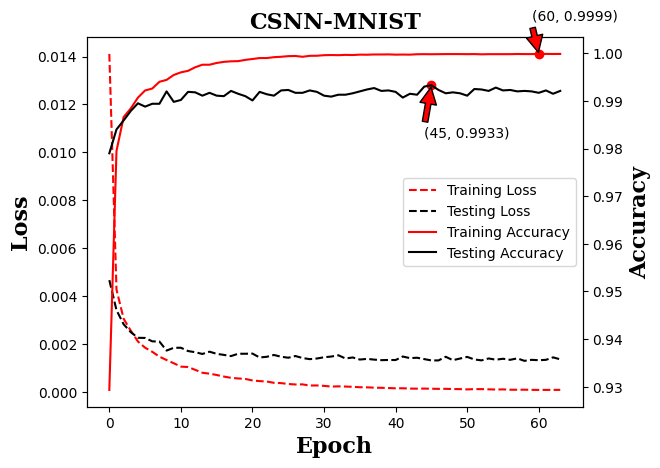

In [18]:
import numpy as np
def drawFig(train_loss, test_loss, train_acc, test_acc):
    fig = plt.figure(1)

    font = {'family' : 'serif', 'color'  : 'black', 'weight' : 'bold', 'size'   : 16,}


    ax1 = fig.add_subplot(111)
    ln1 = ax1.plot(train_loss, 'r--', label='Training Loss')
    ln2 = ax1.plot(test_loss, 'k--', label='Testing Loss')
    ax2 = ax1.twinx()
    ln3 = ax2.plot(train_acc, 'r', label='Training Accuracy')
    idx = np.argmax(train_acc)
    plt.scatter(idx, train_acc[idx], c='r')
    plt.annotate(f'({idx}, {train_acc[idx]:.4f})', (idx, train_acc[idx]), 
             xytext=(idx-1, train_acc[idx]+0.007), 
             arrowprops=dict(facecolor='red', shrink=0.05))
    ln4 = ax2.plot(test_acc, 'k', label='Testing Accuracy')
    idx = np.argmax(test_acc)
    plt.scatter(idx, test_acc[idx], c='r')
    plt.annotate(f'({idx}, {test_acc[idx]:.4f})', (idx, test_acc[idx]), 
             xytext=(idx-1, test_acc[idx]-0.011), 
             arrowprops=dict(facecolor='red', shrink=0.05))
    lns = ln1+ ln2+ ln3+ ln4
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=7)


    ax1.set_ylabel('Loss', fontdict=font)
    ax1.set_title("CSNN-MNIST", fontdict=font)
    ax1.set_xlabel('Epoch', fontdict=font)

    ax2.set_ylabel('Accuracy', fontdict=font)

    plt.show()

drawFig(train_loss_record, test_loss_record, train_acc_record, test_acc_record)

In [19]:
train_loss_record
test_loss_record
train_acc_record
test_acc_record
print(f'max testing accuracy:', max(test_acc_record))
print(f'max training accuracy:',max(train_acc_record))

max testing accuracy: 0.9933
max training accuracy: 0.9998665955176094


In [26]:
def save_list_to_file(lst, filename):
    with open(filename, "w") as file:
        for item in lst:
            file.write(str(item) + "\n")

def read_list_from_file(filename):
    with open(filename, "r") as file:
        lines = file.readlines()
        return [float(line.strip()) for line in lines]




save_list_to_file(train_acc_record, "train_acc.txt")
save_list_to_file(test_acc_record, "test_acc.txt")
save_list_to_file(train_loss_record, "train_loss.txt")
save_list_to_file(test_loss_record, "test_loss.txt")

my_list = read_list_from_file("train_acc.txt")
print(my_list)

[0.9293122998932765, 0.979489060832444, 0.9866095250800427, 0.9884271611526148, 0.990695037353255, 0.9921958377801494, 0.9925960512273212, 0.9940134738527214, 0.9944136872998933, 0.9954475720384205, 0.9959978655282817, 0.9963147011739595, 0.9970651013874067, 0.9975987193169691, 0.9975987193169691, 0.9979655816435432, 0.9981990394877268, 0.9983157684098186, 0.9983491195304163, 0.9986159284951974, 0.9987993596584845, 0.9989994663820705, 0.9989994663820705, 0.9991828975453575, 0.9992662753468516, 0.9993996798292423, 0.9994330309498399, 0.9992662753468516, 0.9994663820704376, 0.9994830576307364, 0.9995997865528282, 0.9996331376734259, 0.9995997865528282, 0.9996664887940235, 0.9996331376734259, 0.9997165154749199, 0.9996998399146211, 0.9997498665955176, 0.9997498665955176, 0.9997665421558164, 0.9997165154749199, 0.9997331910352187, 0.9997165154749199, 0.999799893276414, 0.9998165688367129, 0.999799893276414, 0.9998165688367129, 0.9998332443970117, 0.9998332443970117, 0.9998332443970117, 0.9

In [20]:
checkpoint = {
    'net': net.state_dict(),
    'optimizer': optimizer.state_dict()
}


torch.save(checkpoint, os.path.join('./', 'csnn_mnist.pth'))

C:\Users\CodeAlan\AppData\Local\Temp\ipykernel_12008\2920782351.py:24: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out_fr, label_onehot)


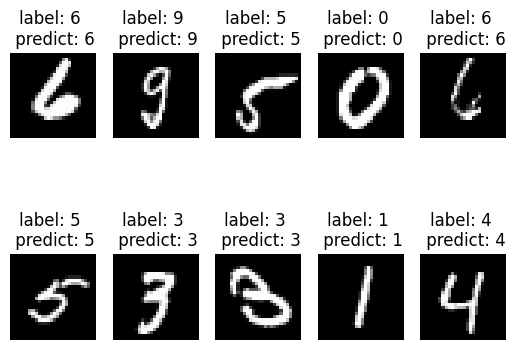

In [21]:
# 图片enumerate

test_data_loader_example = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=True,
)


examples = enumerate(test_data_loader_example)

batch_idx, (imgs, labels) = next(examples)

fig = plt.figure()
#抽取10张图片测试
net.eval()
for i in range(10):
    with torch.no_grad():
        
        img = imgs[i].to(device)
        label = labels[i].to(device)
        label_onehot = F.one_hot(label, 10).float()
        out_fr = net(img)
        loss = F.mse_loss(out_fr, label_onehot)

        test_samples += label.numel()
        test_loss += loss.item() * label.numel()
        test_acc += (out_fr.argmax(1) == label).float().sum().item()
        functional.reset_net(net)


        img = imgs[i].squeeze()
        ax = fig.add_subplot(2, 5, i + 1)
        ax.imshow(img, cmap='gray')
        ax.set_title(f'label: {label} \n predict: {out_fr.argmax(1).item()}')
        ax.axis('off')